In [16]:
import gefera as gf
import numpy as np
import astropy.constants as ac
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Sequence
import celerite2 as ct

In [97]:
p_transit = {
'ap':215.0,
'tp':-91.25,
'ep':0.0,
'pp':365,
'wp':0.1 * np.pi / 180,
'ip':89.8 * np.pi / 180,
'am':2,
'tm': -4.2,
'em' : 0.0,
'pm' : 8,
'om' :90 * np.pi / 180,
'wm' : -90 * np.pi / 180,
'im' : 90.0 * np.pi / 180,
'mm' : 0.01,
'rp' : 0.1,
'rm' : 0.05,
'u1' : 0.5,
'u2' : 0.3,
}
 
po = gf.orbits.PrimaryOrbit(ap, tp, ep, pp, wp, ip)
mo = gf.orbits.SatelliteOrbit(am, tm, em, pm, om, wm, im, mm)
sys = gf.systems.HierarchicalSystem(po, mo)

   
t = np.linspace(-0.6, 0.3, 10000)
# The out-of-transit flux is set to zero by default, so we add 1 to get the normalized flux.
flux = sys.lightcurve(t, u1, u2, rp, rm) + 1

In [98]:
p_transit

{'ap': 215.0,
 'tp': -91.25,
 'ep': 0.0,
 'pp': 365,
 'wp': 0.0017453292519943296,
 'ip': 1.5673056682909077,
 'am': 2,
 'tm': -4.2,
 'em': 0.0,
 'pm': 8,
 'om': 1.5707963267948966,
 'wm': -1.5707963267948966,
 'im': 1.5707963267948966,
 'mm': 0.01,
 'rp': 0.1,
 'rm': 0.05,
 'u1': 0.5,
 'u2': 0.3}

Questions:
Which parameters are in a transit model? A noise model?
How to instantiate a noise model?
By "transit model", does that refer to the sys.lightcurve or just sys?
If p_transit and p_noise have all of the parameters in them, will one of those parameters be an array? Or will we have to pass the funciton another parameter that is an array of values for an independent variable?
When you refer to the plots from the carter paper, are those the ones I recreated? 

white noise vs correlaated noise
correlated - varies smoothely with time
white - completely uncorrelated, two points close intime are not close to each other
light curves have both noises

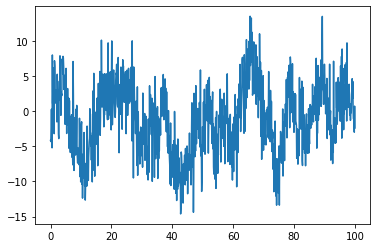

In [11]:
kernel = ct.terms.SHOTerm(rho=10,Q=1/np.sqrt(2),sigma=5)
gp = ct.GaussianProcess(kernel)
t=np.linspace(0,100,1000)
gp.compute(t,diag=10) #diag adds 10 to the diag of the cov matrix, white noise amplitude
plt.plot(t,gp.sample())

In [87]:
#given a transit model and a noise model with parameters with p_transit and p_noise, produce a curve of the fisher info with any of the transit parameters as the independent var
#for each element of the array of independent variables,
	#instantiate a celerite model for the noise
	#instantiate a gefera model for the transit 
	#compute the information matrix using the covariance matrix from celerite and the derivatives from gefera
	#invert the information matrix to get the Cramér-Rao bounds 

#return an array of the inverted information matrices — should have one matrix entry for each element of the original array of independent variables. 

#p_transit is an array of parameters for the transit
#p_noise is an array of parameters for the noise
#**ind_var should just be one parameter and needs to have an expected name

#p_transit(all dynamical params for moon and planet)
#p_noise  use simple harmonic oscillator kernel
#want to be flexible to noise model that we use, can use different celerite models
#simple: use one simple harm term, Q=1/sqrt2
#need white noise param, not part of celerite model

#make p_transit and p_noise dictionaries

#p_noise has rho,sigma,Q,diag


In [100]:
def lc_corr(p_transit,p_noise,**ind_var):
    param = set(p_transit.keys()).intersection(set(ind_var.keys())) #finds if the ind_var is a transit parameter
    key, value = list(ind_var.items())[0]
    if param != {} and len(param) == 1:
        p_transit.update({key:value})
    elif param == set():
        param = set(p_transit.keys()).intersection(set(ind_var.keys()))
        p_noise.update({key:value})
    else:
        return None #if the ind_var is in neither transit nor noise dictionary, return None
    
    t=np.linspace(0,100,1000)
    
    #instantiate noise model
    kernel = ct.terms.SHOTerm(rho=p_noise['rho'], Q=1/np.sqrt(2), sigma=p_noise['sigma'])
    gp = ct.GaussianProcess(kernel)
    gp.compute(t, \diag=p_noise['diag']) #diag adds 10 to the diag of the cov matrix, white noise amplitude
    
    #instantiate transit model
    po = gf.orbits.PrimaryOrbit(p_transit['ap'], p_transit['tp'], p_transit['ep'], p_transit['pp'], p_transit['wp'], p_transit['ip'])
    mo = gf.orbits.SatelliteOrbit(p_transit['am'], p_transit['tm'], p_transit['em'], p_transit['pm'], p_transit['om'], p_transit['wm'], p_transit['im'], p_transit['mm'])
    sys = gf.systems.HierarchicalSystem(po, mo)

    

plots:
covar. of two variables as a function of the changin independent vars

approach:
just return the matrices, otherwise have a ton of plots, we will use our own judgment to decide which covariances are going to be relevant

potentially pass a dictionary --> order doesn't matter unlike array

think about how i want the interface of the function, then think how to do it

maybe pass array of all params except the array


celerite takes care of right two terms of eq 21 in paper

mu is the light curve
dmu/dtheta_i is the deriv of lc w respect to ind var theta_i